# Lab 4
## Causal Inference and Randomized Assignment
2/7/2018

### Announcements:
The next problem set is due at the start of lecture on February 21-- guidelines for submitting the previous problem set hold.  Exercises can be found in modules 4-5.  

### Plan for Today's Lab
1. More regression practice and lm() options (5-10 minutes)
2. Clustering (5 minutes)
3. Simple Randomization (If time-- 5 minutes)


In [1]:
# Clear Environment 
rm(list = ls())

#install.packages("miceadds")
#install.packages("multiwayvcov")

# Load required packages
library(dplyr)
library(ggplot2)
library(miceadds)
library(multiwayvcov)

# Set working directory to the location of your data files
# setwd("/home/jovyan/mba217-2/Data")

# read the file
PanelPROGRESA_97_99year <- read.csv("../Data/PanelPROGRESA_97_99year.csv")
str(PanelPROGRESA_97_99year)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: mice
Loading required package: lattice
* miceadds 2.9-15 (2017-12-18 11:50:04)


'data.frame':	71411 obs. of  12 variables:
 $ year        : int  1998 1998 1999 1998 1999 1998 1999 1998 1999 1998 ...
 $ villid      : int  13030105 13030024 13030024 13030024 13030024 13030105 13030105 13030105 13030105 13030006 ...
 $ geopolid    : int  13 13 13 13 13 13 13 13 13 13 ...
 $ hogid       : int  1 2 2 3 3 4 4 5 5 6 ...
 $ pov_HH      : Factor w/ 2 levels "Non poor","poor": 2 1 1 1 1 2 2 2 2 1 ...
 $ D           : Factor w/ 2 levels "Control","Treated": 2 1 1 1 1 2 2 2 2 2 ...
 $ D_HH        : int  NA 0 0 0 0 NA NA NA NA 0 ...
 $ IncomeLab_HH: num  NA 9000 1200 1200 900 ...
 $ famsize     : int  2 3 3 3 3 5 5 2 2 4 ...
 $ eduhead     : int  NA NA NA NA NA NA NA NA NA NA ...
 $ agehead     : int  70 27 29 55 55 26 27 NA 47 60 ...
 $ sexhead     : Factor w/ 2 levels "Female","Male": 2 2 2 2 2 2 2 2 2 1 ...


## 1-Regression Practice
When we can assert that treatment assignment is random (or "as good" as random) we can use regression to make causal inferences.  As discussed in lecture, PROGRESA was randomly assigned to households over a two year period.  A baseline survey was conducted in 1997, and an endline survey in 1999.  In the problem set, you'll be asked to evaluate the effect of PROGRESA on income.

Let's practice by using a regression to analyze the relationship between income and household head education at baseline.  Can we say that education has a causal effect on income?  Additionally, let's practice displaying the results of this regression in a graph.  

In [3]:
#subset data, baseline only
PROGRESA_97 <- PanelPROGRESA_97_99year[which(PanelPROGRESA_97_99year$year == 1997), ]
#check balance of income at baseline
model <- lm(IncomeLab_HH ~ eduhead, data = PROGRESA_97)
summary(model)


Call:
lm(formula = IncomeLab_HH ~ eduhead, data = PROGRESA_97)

Residuals:
   Min     1Q Median     3Q    Max 
 -1487   -718   -438    197  34662 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1268.279     15.811  80.215  < 2e-16 ***
eduhead       17.381      3.857   4.506 6.63e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1584 on 20229 degrees of freedom
  (3846 observations deleted due to missingness)
Multiple R-squared:  0.001003,	Adjusted R-squared:  0.0009535 
F-statistic: 20.31 on 1 and 20229 DF,  p-value: 6.634e-06


Warning message:
“Removed 3846 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 125 rows containing missing values (geom_point).”

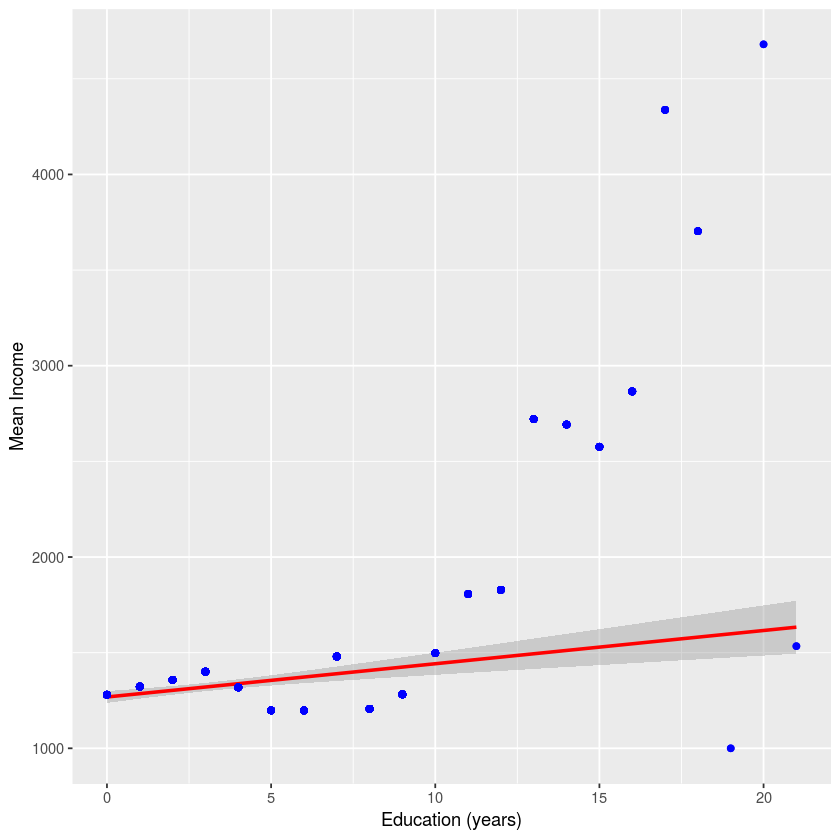

In [4]:
#mean income for each education level
PROGRESA_97 <- PROGRESA_97 %>% group_by(eduhead) %>% mutate(meanincome = mean(IncomeLab_HH, na.rm = TRUE))

#Use ggplot to make a combined scatterplot with regression line of income by education level
L <- PROGRESA_97 %>% ggplot(aes(eduhead, IncomeLab_HH)) 
L <- L + geom_smooth(color='red',method='lm', formula=y~x)
P <- geom_point(color='blue',aes(PROGRESA_97$eduhead, PROGRESA_97$meanincome))
 L+P + xlab("Education (years)") +  ylab("Mean Income")


## 2-Clustering
One of the assumptions critical for regression analysis is random sampling or independence of error: This assumption states that the errors of the outcome variables are uncorrelated with each other Intuitively, it means that each observation of Y is independently draws from the population from other outcomes.

In practice, observations from the same group or place share common characteristics. What if we believe that individuals within a village are influenced by each other and share common facilities, so that there is some “correlation” among their behaviors? Then we have to estimate the standard errors clustered as the village level.  These can be implemented using the lm.cluster command from the multiwayvcov and miceadds packages.

Let's look at the relationship between income and education levels at baseline, this time clustering at the village level.  What happens to the coefficients and standard errors?

In [5]:
#Use lm.cluster 
model2 <- lm.cluster(data = PROGRESA_97, formula=IncomeLab_HH ~ eduhead, cluster=PROGRESA_97$villid)
summary(model2)

R^2 = 0.001 

              Estimate Std. Error   t value     Pr(>|t|)
(Intercept) 1268.27923  30.603609 41.442146 0.0000000000
eduhead       17.38053   5.219523  3.329908 0.0008687482


## 3-Randomization
So far, we've been focusing on how to analyze data that results from a randomized controlled trial.  But when might we use statistical packages like R before we have data, in the design phase?  

We can also use R to randomly select our treatment group.  


In [6]:
#Setting the seed allows results to be reproducible
set.seed(1105)

#Simple randomization
PROGRESA_97$random_T <- round(runif(nrow(PROGRESA_97)),0)
str(PROGRESA_97$random_T)

#Stratified randomization by administrative region
PROGRESA_97 <- PROGRESA_97 %>% group_by(geopolid) %>% mutate(random_strata_T = round(runif(n()),0))
str(PROGRESA_97$random_strata_T)


 num [1:24077] 1 1 1 1 0 0 1 1 1 0 ...
 num [1:24077] 1 0 0 0 1 1 0 1 0 1 ...
